# Final Project - DA 353

## Dr. Bonifonte
## Minh Le & Yen Nguyen


### I. Background and Introduction

The adoption of electric vehicles (EVs) is increasing worldwide, mainly driven by growing awareness of environmental issues and technological advancements. These types of vehicles are now favored and recognized by the majority of consumers. With the increasing number of new energy electric vehicles, the demand for charging stations for these vehicles is also increasing. This makes the strategic placement of charging stations crucial, helping the government optimize infrastructure efficiency by minimizing the need for excessive stations. Finding the right locations for these stations is therefore important, ensuring they can provide convenient access for all EV users, while contributing to a more sustainable future of transportation.

For this project, we aim to optimize the allocation of electric vehicles charging stations locations that effectively minimize the number of stations. We chose Washington state for our optimization model. Since the current data is too large, we plan to focus on the metropolitan area in Washington state, such as Seattle, to reduce the complexity of the problem. Based on the given dataset provided by data.gov about the registered electric vehicles, we are hoping to effectively design and build strategic placements of stations that can cover all the locations and meet the demand of those registered cars.


### II. Data Preprocessing & Exploration
Now, we will select all the data we need for our optimization problem. We will only focus on the biggest city in Washington State, which is Seattle. 

In [1]:
# import packages
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import geopy.distance
import folium
from itertools import combinations, permutations

/Users/minhle/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load datset and select needed columns
df = pd.read_csv("./Electric_Vehicle_Population_Data.csv")
df = df[["VIN (1-10)", "County", "City", "Postal Code", "Electric Range", "Vehicle Location"]]
df.set_index("VIN (1-10)", inplace=True)

In [3]:
# select data that are from Seattle
df_seattle = df.loc[df["City"] == "Seattle"]
df_seattle.head()

,County,City,Postal Code,Electric Range,Vehicle Location
VIN (1-10),,,,,
5YJYGDEE1L,King,Seattle,98122.0,291,POINT (-122.30839 47.610365)
5YJSA1E4XK,King,Seattle,98109.0,270,POINT (-122.34848 47.632405)
5YJYGDEEXL,King,Seattle,98144.0,291,POINT (-122.30823 47.581975)
1N4AZ0CP0F,King,Seattle,98119.0,84,POINT (-122.363815 47.63046)
1N4AZ0CP6D,King,Seattle,98107.0,75,POINT (-122.37815 47.66866)


First, we want to explore the locations of all the registered vehicles. We will use `Postal Code` to identify where the EVs are registered in Seattle.

In [4]:
# select unique postal code in the dataset
unique_postal_codes = df_seattle['Postal Code'].unique()

# how many vehicles are there for each postal code?
postal_code_counts = df_seattle.groupby('Postal Code').size().reset_index(name='Count')

# Create a grid representation using postal codes
grid = {}

# Populate grid with coordinates
for index, row in df_seattle.iterrows():
    code = row['Postal Code']
    log = row["Vehicle Location"].split(" ")[1][1:]
    lat = row["Vehicle Location"].split(" ")[2][:-1]
    grid[code] = (float(lat), float(log))

We will now create a map to see the location of each `Postal Code`:

In [11]:
#Plot the map for model 1
map_mod_1 = folium.Map(location=[47.6062, -122.3321], zoom_start=10.45)
for key, value in grid.items():
    folium.Marker(location=value,
                    popup=key,
                    icon=folium.Icon(color='blue')).add_to(map_mod_1)
        
map_mod_1

### III. Model Formulation

To streamline our project, we make the following assumptions:
- We assume uniform power consumption demand for each vehicle, approximating it based on the average power consumption of electric cars. 
- We consider the construction cost as well as the power capacity of a new station to be consistent across all locations and irrespective of demand variations.
- We assume the location of each vehicles is specified by `Postal Code`.

We want to develop a linear programming model to solve the problem. The structure of the model is:

1. <b> Set: </b>
    - Let $V$ represent the set of vehicles obtained from the dataset.
    - Let $S$ denote the set of candidate charging locations
2. <b> Data: </b>
    - $D$: the maximum certain distance threshold between the charging location and the vehicle
    - $S$: the maximum supply of the charging station

3. <b> Decision Variables: </b>
    - $C_{j}$: Binary variable indicating whether to open the charging station $j$, $j \in S$.
    - $X_{ij}$: Binary variable indicating whether vehicle $i$ ($i \in V$) chooses station $j$ ($j \in S$) for charging service.
4. <b> Objective Function: </b> Minimize the total number of charging stations opened
\begin{equation*} 
\min \displaystyle\sum_{i \in S} C_i
\end{equation*}
5. <b> Constraints: </b>
    - Vehicle Charging Constraint: 
    - Distance Constraint:
    - Supply-Demand Balance Constraint:

### IV. Model Implementation

### V. Sensitiviy Analysis

### VI. Model Validation & Evaluation

### VII. Limitations & Conclusion

### Reference
Washington State Department of Licensing - Electric Vehicle Population Data. Retrieved from: https://catalog.data.gov/dataset/electric-vehicle-population-data

Alternative Fuels Data Center (AFDC) - Electric Vehicle Charging Station Locator. Retrieved from: https://afdc.energy.gov/fuels/electricity-locations#/find/nearest?fuel=ELEC

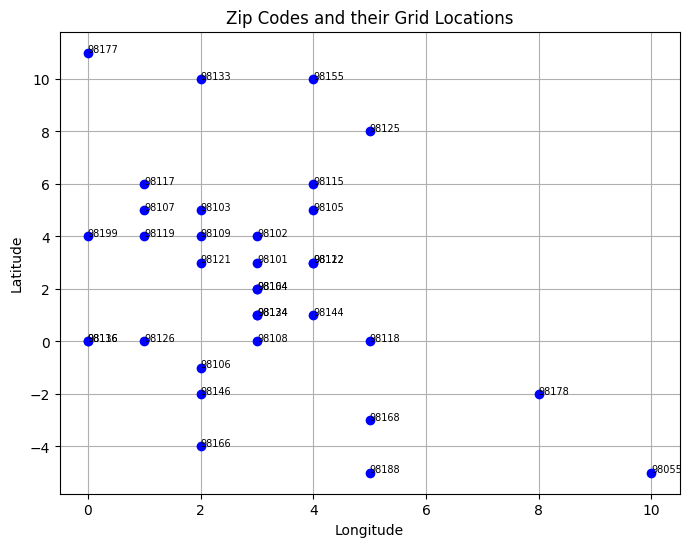

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define longitude and latitude ranges
min_lon, max_lon = -122.4, -122.2  # Example longitude range
min_lat, max_lat = 47.55, 47.75  # Example latitude range

# Define grid size
grid_size = 10

# Function to map longitude and latitude to grid location
def map_to_grid(lon, lat):
    lon_idx = int((lon - min_lon) / (max_lon - min_lon) * grid_size)
    lat_idx = int((lat - min_lat) / (max_lat - min_lat) * grid_size)
    return lon_idx, lat_idx

# Convert coordinates to grid locations
grid_locations = {zipcode: map_to_grid(lon, lat) for zipcode, (lat, lon) in grid.items()}

# Plot grid locations
plt.figure(figsize=(8, 6))
# for zipcode, (lon, lat) in coordinates.items():
#     plt.plot(lon, lat, 'ro')
#     plt.text(lon, lat, str(int(zipcode)), fontsize=8)
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'bo')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Zip Codes and their Grid Locations')
plt.grid(True)
plt.show()


In [32]:
grid

{98122.0: (47.610365, -122.30839),
 98109.0: (47.632405, -122.34848),
 98144.0: (47.581975, -122.30823),
 98119.0: (47.63046, -122.363815),
 98107.0: (47.66866, -122.37815),
 98126.0: (47.54468, -122.374105),
 98118.0: (47.549285, -122.28339),
 98108.0: (47.5499519, -122.3268963),
 98121.0: (47.61546, -122.344125),
 98115.0: (47.67949, -122.3185),
 98101.0: (47.61079, -122.335345),
 98178.0: (47.494545, -122.234385),
 98117.0: (47.68968, -122.37275),
 98125.0: (47.71558, -122.296385),
 98133.0: (47.76726, -122.34584),
 98102.0: (47.64058, -122.32226),
 98112.0: (47.62523, -122.30764),
 98177.0: (47.77279, -122.382425),
 98103.0: (47.659185, -122.34301),
 98104.0: (47.6018, -122.329075),
 98105.0: (47.66132, -122.319115),
 98199.0: (47.639195, -122.394185),
 98106.0: (47.52104, -122.356145),
 98146.0: (47.505655, -122.355145),
 98134.0: (47.57981, -122.329815),
 98116.0: (47.56484, -122.38679),
 98166.0: (47.465925, -122.341345),
 98136.0: (47.5415, -122.388675),
 98155.0: (47.7578146, 